In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from feature_engineering import *

In [2]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [60]:
sns.set(font='Lato', font_scale=1.5)

In [70]:
def predict_profit(X, profit, clf, bins=20):
    """
    Estimate total profit as a percentage of the population called.
    
    """
    predicted_df = pd.DataFrame()
    predicted_df['profit'] = profit
    predicted_df['proba'] = clf.predict_proba(X)[:, 1]
    predicted_df['expected_profit'] = predicted_df['profit']*predicted_df['proba']
    predicted_df['bin_positive'] = pd.qcut(predicted_df['expected_profit'], bins)
    binned_profit = []
    for bin_id, data in predicted_df.groupby('bin_positive'):
        binned_profit.append(data['profit'].sum())
    binned_profit.append(0)
    return predicted_df, np.array(binned_profit[::-1]).cumsum()

### Read features and target from file

In [3]:
feature_target_file = '../output/bank_all_features_target.csv'
feature_target_df = pd.read_csv(feature_target_file)
features_df, target = extract_features_target(feature_target_df)

### Add the net profit per customer

In [16]:
profit = target*features_df['balance']*0.01-1
features_df['profit'] = profit

## Train/test split, make sure split the profit column
Then extract the features and the profit separately

In [87]:
X_train_profit, X_test_profit, y_train, y_test = train_test_split(features_df.values, target, test_size=0.2, random_state=42)
X_train = X_train_profit[:, :-1]
X_test = X_test_profit[:, :-1]
profit_train = X_train_profit[:,-1]
profit_test = X_test_profit[:, -1]

## Build models
1. Logistic Regression
2. Random Forest
3. Gradient Boosting

In [88]:
lr_pipe = make_pipeline(StandardScaler(), LogisticRegression(C=10))
lr_pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [90]:
forest = RandomForestClassifier(class_weight={0: 1, 1:10}, max_depth=10, max_features=10, n_estimators=100)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 10},
            criterion='gini', max_depth=10, max_features=10,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [91]:
gbrt = GradientBoostingClassifier(max_depth=5, n_estimators=200, learning_rate=0.25)
gbrt.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.25, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

## Make prediction

In [92]:
bins = 50
ratios = 1./(bins)*np.arange(bins+1)*100
_, cum_profit_lr = predict_profit(X_test, profit_test, lr_pipe, bins=bins)
predicted_df, cum_profit_rf = predict_profit(X_test, profit_test, forest, bins=bins)
_, cum_profit_gbrt = predict_profit(X_test, profit_test, gbrt, bins=bins)

## Plot predicted profit versus customers called

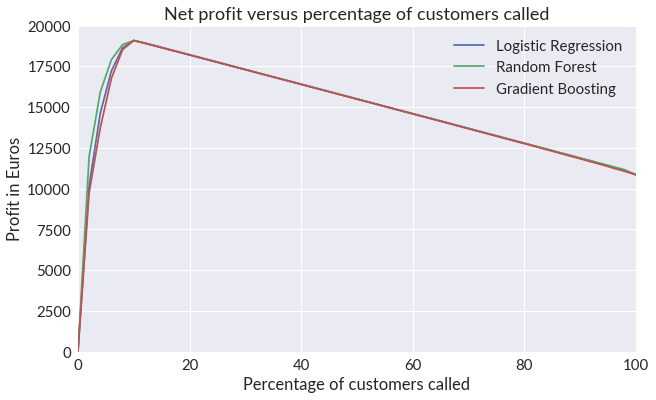

In [93]:
plt.figure(figsize=(10, 6))
plt.plot(ratios, cum_profit_lr, label='Logistic Regression')
plt.plot(ratios, cum_profit_rf, label='Random Forest')
plt.plot(ratios, cum_profit_gbrt, label='Gradient Boosting')
plt.ylabel('Profit in Euros')
plt.xlabel('Percentage of customers called')
plt.xlim(0, 100)
plt.ylim(0, 20000)
plt.legend()
plt.title("Net profit versus percentage of customers called");

## Estimate maximum profit obtained

In [84]:
max_profit, ratio_called = np.max(cum_profit_rf), np.argmax(cum_profit_rf)*1./bins*100

In [ ]:
len(max)